In [12]:
from torch.utils.data import DataLoader
from diffusers.utils import make_image_grid
from tqdm.auto import tqdm
from data.utils import tensor_to_images
import os
import torch
import torch.nn as nn
import json


class VAETrainingPipeline:
    def __init__(self,
                 vae: nn.Module,
                 dataloader: DataLoader,
                 val_dataloader: DataLoader,
                 device='cuda',
                 ):
        self.device = device
        self.vae = vae.to(device)
        self.dataloader = dataloader
        self.val_dataloader = val_dataloader

    def train(self,
              name: str,
              output_dir: str,
              epochs: int,
              optimizer: torch.optim.Optimizer,
              lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
              sample_period=3,
              ):
        output_dir = os.path.join(output_dir, name)
        os.makedirs(output_dir)
        os.makedirs(os.path.join(output_dir, 'samples'))

        loss_per_epoch = []

        mse = nn.MSELoss()
        val_batch = next(iter(self.val_dataloader)).to(self.device)

        training_progress = tqdm(range(epochs), position=0)
        try:
            for epoch in training_progress:
                training_progress.set_description("Epoch:")

                self.vae.train()
                running_loss = 0
                epoch_progress = tqdm(self.dataloader, position=1, leave=False)
                for timestep, batch in enumerate(epoch_progress):
                    epoch_progress.set_description("Batch:")
                    batch = batch.to(self.device)

                    seed = torch.normal(0, 1, size=(
                        batch.shape[0], 4, batch.shape[2]//8, batch.shape[3]//8), device=self.device)

                    decoded_image, mean, logvar = self.vae(batch, seed)

                    rec_loss = mse(decoded_image, batch)
                    kl_loss = -0.5 * \
                        torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                    loss = rec_loss + kl_loss * 1e-8
                    loss.backward()
                    optimizer.step()
                    if lr_scheduler is not None:
                        lr_scheduler.step()
                    optimizer.zero_grad()
                    running_loss += loss.item()
                    postfix = {'loss': loss.item()}
                    if lr_scheduler is not None:
                        postfix['lr'] = lr_scheduler.get_last_lr()[0]
                    epoch_progress.set_postfix(postfix)

                loss_per_epoch.append(running_loss / len(self.dataloader))
                if (epoch + 1) % sample_period == 0:
                    self.vae.eval()
                    images = val_batch
                    seed = torch.normal(0, 1, size=(
                        8, 4, images.shape[2]//8, images.shape[3]//8)).to(self.device)
                    with torch.no_grad():
                        decoded_images = self.vae(images, seed)[0]

                    output_images = tensor_to_images(torch.stack(
                        [images, decoded_images], dim=1).view(16, 3, images.shape[2], images.shape[3]))
                    grid = make_image_grid(output_images, rows=4, cols=4)
                    grid.save(f'{output_dir}/samples/{epoch:04d}.png')

        finally:
            torch.save(self.vae.state_dict(),
                       f'{output_dir}/vae.safetensors')
            with open(f'{output_dir}/loss.json', 'w') as f:
                json.dump(loss_per_epoch, f)
            print(f"[+] Training stopped. Results saved to {output_dir}")

In [13]:
from model.vae.vae import VAE
import torchvision.transforms as transforms
from data.image_dataset import ImageDataset
from diffusers import get_cosine_schedule_with_warmup
from torch.utils.data import Subset
import torch

dataset = ImageDataset('../datasets/VAE_train', transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

# subset = Subset(dataset, range(300))
val_dataset = ImageDataset('../datasets/VAE_val', transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True,
                        num_workers=8, prefetch_factor=2)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

epochs = 50
vae = VAE().cuda()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=500, num_training_steps=len(dataloader) * epochs)


training_pipeline = VAETrainingPipeline(
    vae=vae,
    dataloader=dataloader,
    val_dataloader=val_dataloader,
    device='cuda'
)

In [14]:
from torchinfo import summary

summary(vae)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─VAEEncoder: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─VAEResidualBlock: 2-2             --
│    │    └─GroupNorm: 3-1               64
│    │    └─Conv2d: 3-2                  9,248
│    │    └─GroupNorm: 3-3               64
│    │    └─Conv2d: 3-4                  9,248
│    │    └─Identity: 3-5                --
│    └─VAEResidualBlock: 2-3             --
│    │    └─GroupNorm: 3-6               64
│    │    └─Conv2d: 3-7                  9,248
│    │    └─GroupNorm: 3-8               64
│    │    └─Conv2d: 3-9                  9,248
│    │    └─Identity: 3-10               --
│    └─Conv2d: 2-4                       9,248
│    └─VAEResidualBlock: 2-5             --
│    │    └─GroupNorm: 3-11              64
│    │    └─Conv2d: 3-12                 18,496
│    │    └─GroupNorm: 3-13              128
│    │    └─Conv2d: 3-14                 36,928
│ 

In [15]:
training_pipeline.train(
    'vae_base_nighttune',
    '../runs',
    epochs=epochs,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    sample_period=1
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

[+] Training stopped. Results saved to ../runs/vae_base_nighttune


In [ ]:
vae = VAE()
vae.load_state_dict(torch.load('../runs/vae_base_nighttune/vae.safetensors'))

i = 205
decoded = vae(dataset[i].unsqueeze(0), torch.normal(0, 1, size=(1, 4, 32, 32)))[0]
decoded = vae.decoder(torch.normal(0, 1, size=(1, 4, 32, 32)))[0]
tensor_to_images(dataset[i].unsqueeze(0))[0]
tensor_to_images(decoded)[0]

TypeError: VAEDecoder.forward() takes 2 positional arguments but 3 were given

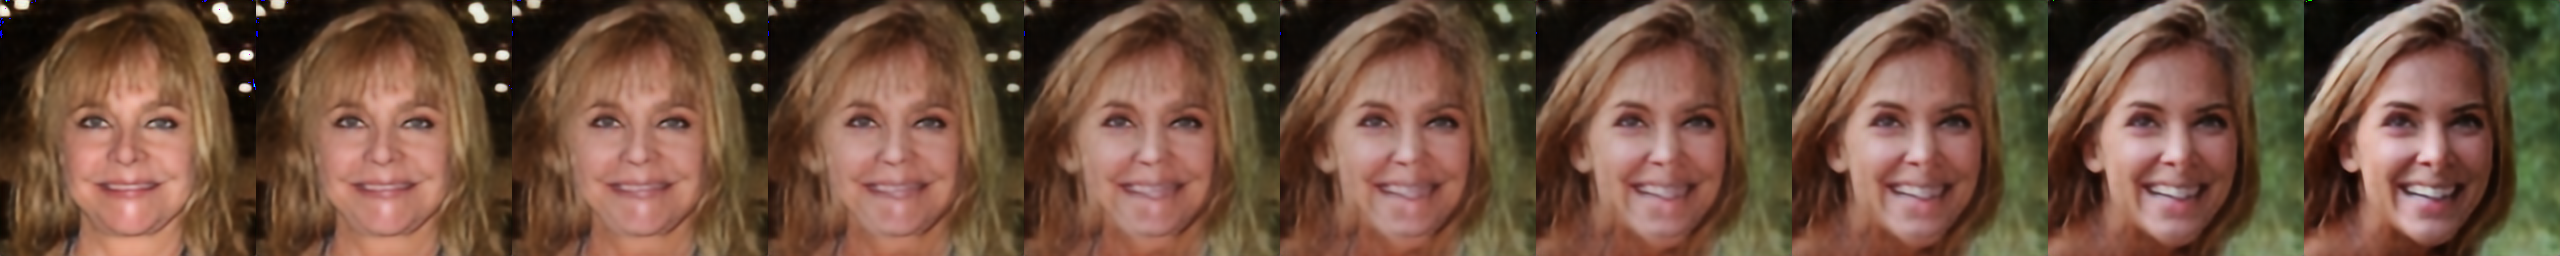

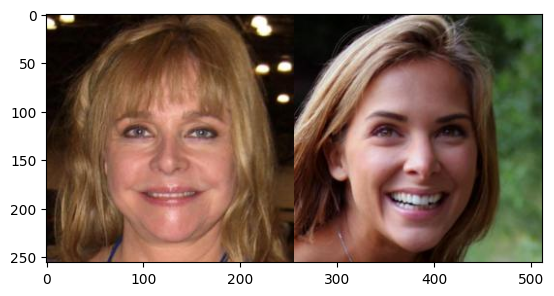

In [51]:
import matplotlib.pyplot as plt

img1 = dataset[100]
img2 = dataset[205]
seed = torch.normal(0, 1, (4, 32, 32))

latent1 = vae.encoder(img1.unsqueeze(0), seed)[0]
latent2 = vae.encoder(img2.unsqueeze(0), seed)[0]

outs = []
for i in torch.arange(0.0, 1.0, 0.1):
    latent3 = i * latent2 + (1-i) * latent1
    out = vae.decoder(latent3)
    outs.append(out[0])

images = tensor_to_images(torch.stack([img1, img2]))
plt.imshow(make_image_grid(images, rows=1, cols=2))

new_images = tensor_to_images(torch.stack(outs))
make_image_grid(new_images, rows=1, cols=len(outs))